# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [54]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [55]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 23, 28, 37, 477064)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [56]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
os.environ["HOPSWORKS_API_KEY"] = "a2V7CkXH6zHDmPM8.vxLleBS2ZBHWQBCpBivhTjVeBDfPV2hqIUtfezXKxtMbdD3Ih4ruIGYlg6AzpsKI"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169566
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [58]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [59]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.549615E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [38]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
4,2024-11-19 00:00:00+00:00,21.250000,0.0,31.559086,32.421055,hsinchu,53.004524,min zu road,taiwan,1
5,2024-11-20 00:00:00+00:00,21.450001,0.0,33.270313,35.753979,hsinchu,58.308136,min zu road,taiwan,2
0,2024-11-21 00:00:00+00:00,20.600000,0.0,29.882166,36.179718,hsinchu,60.120972,min zu road,taiwan,3
2,2024-11-22 00:00:00+00:00,19.299999,0.0,31.942772,39.970871,hsinchu,45.115822,min zu road,taiwan,4
1,2024-11-23 00:00:00+00:00,19.299999,0.0,33.425762,41.069725,hsinchu,47.518040,min zu road,taiwan,5
3,2024-11-24 00:00:00+00:00,19.250000,0.0,27.217524,37.476254,hsinchu,54.496223,min zu road,taiwan,6


In [39]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         6 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          6 non-null      float32            
 2   precipitation_sum            6 non-null      float32            
 3   wind_speed_10m_max           6 non-null      float32            
 4   wind_direction_10m_dominant  6 non-null      float32            
 5   city                         6 non-null      object             
 6   predicted_pm25               6 non-null      float32            
 7   street                       6 non-null      object             
 8   country                      6 non-null      object             
 9   days_before_forecast_day     6 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [30]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
4,2024-11-19 00:00:00+00:00,21.250000,0.0,31.559086,32.421055,hsinchu,53.004524,min zu road,taiwan,1
5,2024-11-20 00:00:00+00:00,21.450001,0.0,33.270313,35.753979,hsinchu,58.308136,min zu road,taiwan,2
0,2024-11-21 00:00:00+00:00,20.600000,0.0,29.882166,36.179718,hsinchu,60.120972,min zu road,taiwan,3
2,2024-11-22 00:00:00+00:00,19.299999,0.0,31.942772,39.970871,hsinchu,45.115822,min zu road,taiwan,4
1,2024-11-23 00:00:00+00:00,19.299999,0.0,33.425762,41.069725,hsinchu,47.518040,min zu road,taiwan,5
3,2024-11-24 00:00:00+00:00,19.250000,0.0,27.217524,37.476254,hsinchu,54.496223,min zu road,taiwan,6


In [31]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         6 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          6 non-null      float32            
 2   precipitation_sum            6 non-null      float32            
 3   wind_speed_10m_max           6 non-null      float32            
 4   wind_direction_10m_dominant  6 non-null      float32            
 5   city                         6 non-null      object             
 6   predicted_pm25               6 non-null      float32            
 7   street                       6 non-null      object             
 8   country                      6 non-null      object             
 9   days_before_forecast_day     6 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

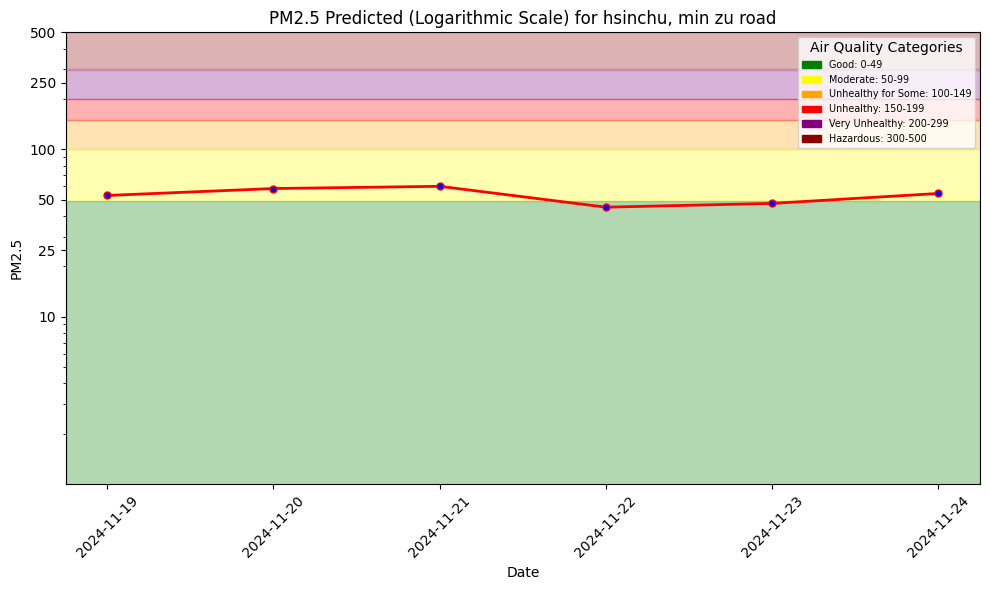

In [48]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [41]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [42]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/6 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169566/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x27d435c3340>, None)

In [50]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
# monitoring_df

monitoring_df = monitor_fg.read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-23 00:00:00+00:00,19.299999,0.0,33.425762,41.069725,hsinchu,47.518040,min zu road,taiwan,4
1,2024-11-19 00:00:00+00:00,21.250000,0.0,31.559086,32.421055,hsinchu,53.004524,min zu road,taiwan,8
2,2024-11-16 00:00:00+00:00,24.100000,0.1,14.973577,27.181028,hsinchu,76.154572,min zu road,taiwan,1
3,2024-11-17 00:00:00+00:00,22.500000,0.2,27.534704,41.820091,hsinchu,54.453106,min zu road,taiwan,7
4,2024-11-18 00:00:00+00:00,20.700001,0.0,39.595085,40.205708,hsinchu,43.072289,min zu road,taiwan,3
5,2024-11-24 00:00:00+00:00,19.250000,0.0,27.217524,37.476254,hsinchu,54.496223,min zu road,taiwan,6
6,2024-11-20 00:00:00+00:00,21.450001,0.0,33.270313,35.753979,hsinchu,58.308136,min zu road,taiwan,9
7,2024-11-21 00:00:00+00:00,20.600000,0.0,29.882166,36.179718,hsinchu,60.120972,min zu road,taiwan,2
8,2024-11-22 00:00:00+00:00,19.299999,0.0,31.942772,39.970871,hsinchu,45.115822,min zu road,taiwan,5
9,2024-11-15 00:00:00+00:00,23.950001,0.0,4.394360,145.007904,hsinchu,82.993820,min zu road,taiwan,1


In [51]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 


,date,pm25,country,city,street,url
0,2020-03-28 00:00:00+00:00,30.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
1,2023-11-13 00:00:00+00:00,50.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
2,2021-07-22 00:00:00+00:00,26.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
3,2018-05-10 00:00:00+00:00,57.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
4,2020-09-04 00:00:00+00:00,61.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
...,...,...,...,...,...,...
3926,2023-07-25 00:00:00+00:00,30.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
3927,2023-05-05 00:00:00+00:00,53.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
3928,2018-11-05 00:00:00+00:00,50.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609
3929,2015-11-18 00:00:00+00:00,83.0,taiwan,hsinchu,min zu road,https://api.waqi.info/feed/@1609


In [52]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-15 00:00:00+00:00,82.993820,99.0
0,2024-11-18 00:00:00+00:00,43.072289,21.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

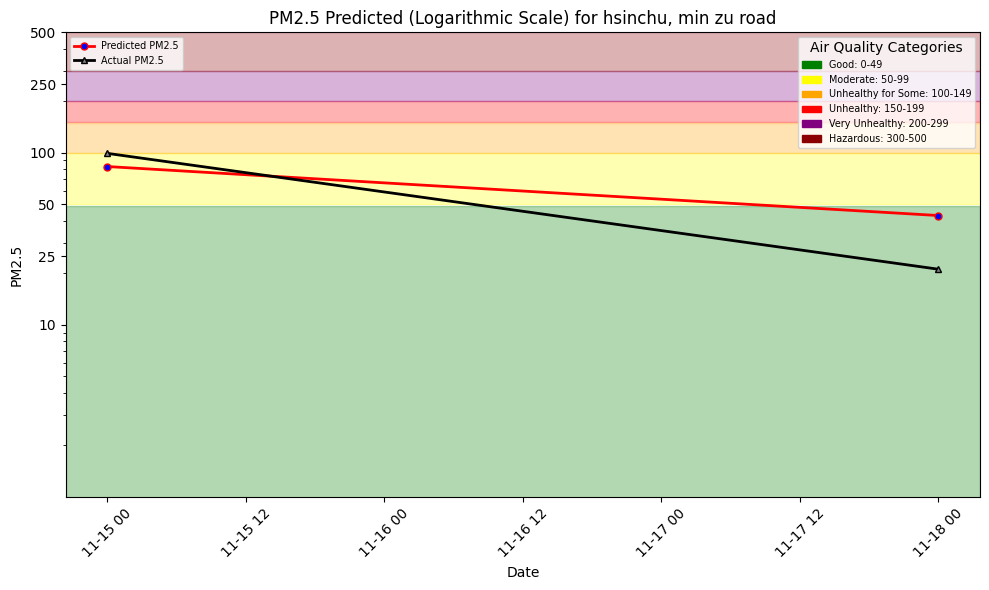

In [53]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---